# UpSet plots with PyKrev 

* 1.1: **UpSet Plots** are an effective way of visualising intersections of three or more sets. This is particularly useful when we want to compare high resolution mass spectrometry data between multiple samples. An implementation of UpSet plots in Python is [UpSetPlot](https://pypi.org/project/UpSetPlot/) which you will need to install before performing the following analysis. This analysis was made with upsetplot version 0.4.1.

In [1]:
import os
import upsetplot #the upsetplot implementation in python we are using to make upset plots
import matplotlib.pyplot as plt
import pandas as pd
import pykrev as pk

* 1.2: Read in the example formula using ```read_formularity```. 

In [2]:
A_formula, A_peak_intensity, A_mass = pk.read_formularity('../example_data/formularity_example_A.csv',pi_col = 'peak_intensity') 
B_formula,B_peak_intensity, B_mass = pk.read_formularity('../example_data/formularity_example_B.csv',pi_col = 'peak_intensity')
C_formula,C_peak_intensity, C_mass = pk.read_formularity('../example_data/formularity_example_C.csv',pi_col = 'peak_intensity')

* 1.3: There are two ways in which we can use PyKrev with UpSetPlot to produce upset plots based on our data. <br> Method 1 is simpler, but does not allow us to customise the plots as much.

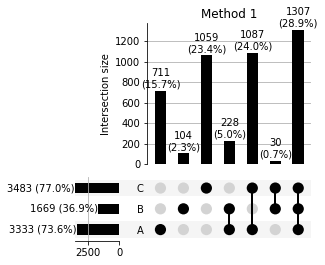

In [3]:
#Method 1 using pk.find_intersections and upsetplot.from_memberships 
intersections = pk.find_intersections([A_formula,B_formula,C_formula],['A','B','C'],exclusive = True) #use PyKrev to find intersections
categories = [list(key) for key in intersections] #extract the category names from intersections
data = [len(value) for value in intersections.values()] #extract the intersection size 
series  = upsetplot.from_memberships(categories,data) #build a series containing the intersection names and the size
upsetplot.plot(series,orientation = 'horizontal',show_percentages = True,show_counts = True, sort_categories_by = None) #make an upset plot
title = plt.title('Method 1')

* 1.4: Method 2 is a little more complex, but allows us to add additional catplots above each intersection to give more information about the formula in that intersection. In the example below, I use catplots to show the distribution of double bond equivalence and oxygen atom number, as well as the proportion of compound class types in each intersection based on AI mod and HC ratios (see [Kellerman et al. (2014)](https://www.nature.com/articles/ncomms4804)).

Text(0, 0.5, 'Sample')

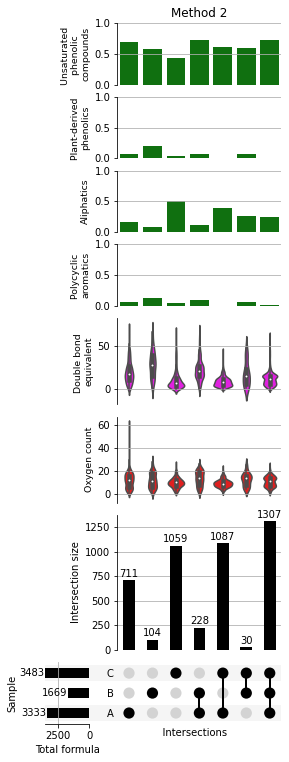

In [4]:
#Method 2 using upsetplot.from_contents and cat plots

sample_dict={'A':set(A_formula),'B':set(B_formula),'C':set(C_formula)} 
sample_upset = upsetplot.from_contents(sample_dict) #create the series needed for the upsetplot using from_contents (this calculates the intersections automatically)

formula_to_analyse = sample_upset['id'] #a set of all the formula across all the samples

counts = pk.element_counts(formula_to_analyse) #calculate the element counts for all the formula
o_number = [c['O'] for c in counts] #calculate the oxygen number for all the formula
dbe = pk.double_bond_equivalent(formula_to_analyse) #calculate the double bond equivalence for all the formula
aimod = pk.aromaticity_index(formula_to_analyse) #calculate the modified aromaticity index for all the formula 
ratios = pk.element_ratios(formula_to_analyse) #calculate the element ratios for all the formula


#below we are going to calculate the compound class of all formula based on AI and HC ratio
#rules are based on: https://www.nature.com/articles/ncomms4804
polycyclic_aromatics = []
polyphenols = []
unsat = []
aliph = []

for ai,ratio in zip(aimod,ratios):

    if ai > 0.66: 
        polycyclic_aromatics.append(1)
    else: polycyclic_aromatics.append(0)
    if ai > 0.5 and ai <= 0.66:
        polyphenols.append(1)
    else: polyphenols.append(0)
    if ai <= 0.5 and ratio['HC'] < 1.5: 
        unsat.append(1)
    else: unsat.append(0)
    if ai <= 0.5 and ratio['HC'] >= 1.5:
        aliph.append(1)
    else: aliph.append(0)
    
    
#create a new dataframe including all the additional data    
data_add = pd.DataFrame({'DBE':dbe,'Oxygen':o_number,'Polycyclic Aromatics':polycyclic_aromatics,'Aliphatics':aliph,
                         'Plant-derived phenolics':polyphenols,'Unsaturated phenolics':unsat,'Compound':formula_to_analyse})
#index the dataframe by the molecular formula
data_add = data_add.set_index('Compound')
#reperform the intersection analysis including the additional data 
re_upset = upsetplot.from_contents(sample_dict,data=data_add)
#perform upset analysis on the resulting series
upset = upsetplot.UpSet(re_upset,show_counts = True, show_percentages = False,sort_categories_by = None)

#add catplots corresponding to the calculated values, violin plots for distributions 
upset.add_catplot(value='Oxygen', kind='violin', color='red',elements = 4)
upset.add_catplot(value='DBE', kind='violin', color='magenta',ci = None,elements = 4)
#bar plots for compound class counts 
upset.add_catplot(value='Polycyclic Aromatics', kind='bar', color='green',ci = None)
upset.add_catplot(value='Aliphatics', kind='bar', color='green',ci = None)
upset.add_catplot(value='Plant-derived phenolics', kind='bar', color='green',ci = None)
upset.add_catplot(value='Unsaturated phenolics', kind='bar', color='green',ci = None)

#finally make the plot and save the returned handles 
upset_returns = upset.plot()

title = plt.title('Method 2')

#label the axis of the catplots 
upset_returns['extra1'].set_ylabel('Oxygen count', fontsize = 9.4) # Y label
upset_returns['extra2'].set_ylabel('Double bond \nequivalent', fontsize = 9.4) # Y label

#set y lims between 0 and 1 
upset_returns['extra3'].set_ylim(0,1)
upset_returns['extra3'].set_ylabel('Polycyclic \naromatics', fontsize = 9.4) # Y label

upset_returns['extra4'].set_ylim(0,1)
upset_returns['extra4'].set_ylabel('Aliphatics', fontsize = 9.4) # Y label

upset_returns['extra5'].set_ylim(0,1)
upset_returns['extra5'].set_ylabel('Plant-derived \nphenolics', fontsize = 9.4) # Y label

upset_returns['extra6'].set_ylim(0,1)
upset_returns['extra6'].set_ylabel('Unsaturated \nphenolic \ncompounds', fontsize = 9.4) # Y label

upset_returns['totals'].set_xlabel('Total formula')
upset_returns['shading'].set_xlabel('                    Intersections')
upset_returns['shading'].set_ylabel('Sample', labelpad = 28)

1.5 :That's everything! Of course you don't have to include compund class, oxygen counts or double bond equivalence, but whatever parameters are of interest. **Happy upsetting**. 

* Contact: ezra.kitson@ed.ac.uk
* Last updated: 15/01/2021
